# LANL Earthquake Prediction Kaggle Competition 2019
### Eric Yap, Joel Huang, Kyra Wang

---

In this notebook, we present our work for the LANL Earthquake Prediction Kaggle Competition 2019. The goal of this competition is to use seismic signals to predict the timing of laboratory earthquakes. The data comes from a well-known experimental set-up used to study earthquake physics. The `acoustic_data` input signal is used to predict the time remaining before the next laboratory earthquake (`time_to_failure`).

The training data is a single, continuous segment of experimental data. The test data consists of a folder containing many small segments. The data within each test file is continuous, but the test files do not represent a continuous segment of the experiment; thus, the predictions cannot be assumed to follow the same regular pattern seen in the training file.

For each `seg_id` in the test folder, we need to predict a single `time_to_failure` corresponding to the time between the last row of the segment and the next laboratory earthquake.

---

### Imports

In [18]:
!pip install torchsummary --user

In [1]:
from __future__ import print_function, division, absolute_import

# Data wrangling imports
import numpy as np
import pandas as pd
from scipy import signal
from sklearn.preprocessing import StandardScaler

# Utility imports
import os
import os.path
import time
import math
import ast
import copy
from collections import OrderedDict
from datetime import datetime
from tqdm import tqdm
from joblib import Parallel, delayed

# Data visualization imports
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import seaborn as sns
from lr_finder import LRFinder

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Parameter
from torch.nn.utils import weight_norm
from torch.autograd import Variable, Function
import torch.optim as optim
import torch.utils.data as data
from torchvision import transforms
from torchsummary import summary

In [2]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

torch.backends.cudnn.benchmark = True

# Setting the seeds for reproducibility
np.random.seed(42)
if use_cuda:
    torch.cuda.manual_seed_all(42)
else:
    torch.manual_seed_all(42)

### Data preprocessing

As the training data and the test data are formatted differently, we must either preprocess the data such that the formats of both sets are the same, or ensure that our model is capable of predicting on the two different formats. We went with the first option because it is less time consuming to implement.

We did this by splitting the training data into segments the same size as the test data segments, i.e. 150000 data points each. Each segment is labeled with a single `time_to_failure` corresponding to the time between the last row of the segment and the next laboratory earthquake. We then put each of these segments into a single dataframe, and saved this as a pickle file to be used as our training data.

Following this, we merged the separate test segments into another single dataframe, and saved this as a pickle file to be used as our test data.

As the dataset is massive, we used Joblib to help run the functions as a pipeline jobs with parallel computing.

In [3]:
class FeatureGenerator(object):
    def __init__(self, dtype, n_jobs=1, chunk_size=None):
        self.chunk_size = chunk_size
        self.dtype = dtype
        self.filename = None
        self.n_jobs = n_jobs
        self.test_files = []
        if self.dtype == 'train':
            self.filename = './data/train.csv'
            self.total_data = int(629145481 / self.chunk_size)
        else:
            submission = pd.read_csv('./data/sample_submission.csv')
            for seg_id in submission.seg_id.values:
                self.test_files.append((seg_id, './data/test/' + seg_id + '.csv'))
            self.total_data = int(len(submission))

    def read_chunks(self):
        if self.dtype == 'train':
            iter_df = pd.read_csv(self.filename, iterator=True, chunksize=self.chunk_size,
                                  dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})
            for counter, df in enumerate(iter_df):
                x = df.acoustic_data.values
                y = df.time_to_failure.values[-1]
                seg_id = 'train_' + str(counter)
                yield seg_id, x, y
        else:
            for seg_id, f in self.test_files:
                df = pd.read_csv(f, dtype={'acoustic_data': np.int16})
                x = df.acoustic_data.values
                yield seg_id, x, -999

    def features(self, x, y, seg_id):
        feature_dict = dict()
        feature_dict['target'] = y
        feature_dict['segment'] = x
        feature_dict['seg_id'] = seg_id

        # create features here
        # for example:
        # feature_dict['mean'] = np.mean(x)

        return feature_dict

    def generate(self):
        feature_list = []
        res = Parallel(n_jobs=self.n_jobs,
                       backend='threading')(delayed(self.features)(x, y, s)
                                            for s, x, y in tqdm(self.read_chunks(), total=self.total_data))
        for r in res:
            feature_list.append(r)
        return pd.DataFrame(feature_list)


training_fg = FeatureGenerator(dtype='train', n_jobs=4, chunk_size=150000)
training_data = training_fg.generate()

test_fg = FeatureGenerator(dtype='test', n_jobs=4, chunk_size=None)
test_data = test_fg.generate()

scaler = StandardScaler()
for segment in training_data.segment:
    scaler.partial_fit(segment.astype(float).reshape(-1, 1))

training_data['segment'] = training_data['segment'].map(lambda x: scaler.transform(x.astype(float).reshape(-1, 1)).flatten())
test_data['segment'] = test_data['segment'].map(lambda x: scaler.transform(x.astype(float).reshape(-1, 1)).flatten())

training_data.to_pickle('./data/train_features.pkl')
test_data.to_pickle('./data/test_features.pkl')

4195it [01:50, 38.03it/s]                          
100%|██████████| 2624/2624 [00:30<00:00, 86.78it/s]


In [3]:
trainval_df = pd.read_pickle('./data/train_features.pkl')
trainval_df = trainval_df[trainval_df.segment.map(len) == 150000]

trainval_df.head()

,seg_id,segment,target
0,train_0,"[0.6967899047904469, 0.13790730252484593, 0.32...",1.430797
1,train_1,"[0.04476020214724577, 0.13790730252484593, 0.3...",1.391499
2,train_2,"[0.04476020214724577, 0.04476020214724577, 0.3...",1.353196
3,train_3,"[0.04476020214724577, -0.8867108016287559, -0....",1.313798
4,train_4,"[0.6967899047904469, 0.13790730252484593, -0.0...",1.274400


In [4]:
test_df = pd.read_pickle('./data/test_features.pkl')

test_df.head()

,seg_id,segment,target
0,seg_00030f,"[-0.0483868982303544, -0.42097529974075504, -0...",-999
1,seg_0012b5,"[0.04476020214724577, 0.32420150328004627, 0.3...",-999
2,seg_00184e,"[0.32420150328004627, -0.23468109898555473, -0...",-999
3,seg_003339,"[-0.23468109898555473, 0.13790730252484593, -0...",-999
4,seg_0042cc,"[0.04476020214724577, -0.14153399860795457, -0...",-999


At this point, we split the training data further into a 80/20 training/validation split. We then create dataloaders that will help load the data into the model in parallel using multiprocessing workers.

In [5]:
msk = np.random.rand(len(trainval_df)) < 0.8
train_df = trainval_df[msk]
valid_df = trainval_df[~msk]

train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)

print('Training data is {} of the data'.format(len(train_df)/len(trainval_df)))

Training data is 0.8001907486886027 of the data


In [6]:
class LANL_Dataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, df):
        'Initialization'
        self.seg_id = df['seg_id']
        self.X = df['segment']
        self.y = df['target']

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.y)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Load data and get label
        seg_id = self.seg_id[index]
        X = torch.from_numpy(self.X[index]).float().unsqueeze(0)
        y = torch.from_numpy(np.array([self.y[index]])).float()
        sample = {'seg_id': seg_id, 'X': X, 'y': y}

        return sample
    
class LANL_Dataset_LR(data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, df):
        'Initialization'
        self.seg_id = df['seg_id']
        self.X = df['segment']
        self.y = df['target']

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.y)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Load data and get label
        seg_id = self.seg_id[index]
        X = torch.from_numpy(self.X[index]).float().unsqueeze(0)
        y = torch.from_numpy(np.array([self.y[index]])).float()
        sample = (X, y)

        return sample

### Defining the Model

In [7]:
class LANL_Ressubblock(nn.Module):
    
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 padding):
        super(LANL_Ressubblock, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding)
        self.bn = nn.BatchNorm1d(out_channels)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return x
    

class LANL_Resblock(nn.Module):
    
    def __init__(self,
                 in_channels,
                 out_channels):
        super(LANL_Resblock, self).__init__()
        
        self.subblocks = nn.Sequential(
            LANL_Ressubblock(in_channels, out_channels, 7, 3),
            nn.ReLU(),
            LANL_Ressubblock(out_channels, out_channels, 5, 2),
            nn.ReLU(),
            LANL_Ressubblock(out_channels, out_channels, 3, 1)
        )
        
        if (in_channels != out_channels):
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, 1),
                nn.BatchNorm1d(out_channels)
            )
        else:
            self.shortcut = nn.BatchNorm1d(out_channels)

        self.relu = nn.ReLU()

    def forward(self, x):
        x1 = self.subblocks(x)
        x2 = self.shortcut(x)
        x = x1 + x2
        x = self.relu(x)
        return x
    
    
class LANL_Resnet(nn.Module):
    
    def __init__(self,
                 n_output=1):
        
        super(LANL_Resnet, self).__init__()
        self.blocks = nn.Sequential(
            LANL_Resblock(1, 64),
            LANL_Resblock(64, 128),
            LANL_Resblock(128, 128)
        )
        
        self.gap = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(128, n_output)

    def forward(self, x):
        x = self.blocks(x)
        x = self.gap(x).squeeze(-1)
        x = self.fc(x)
        return x

In [8]:
model = LANL_Resnet().to(device)
summary(model, (1, 150000))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1           [-1, 64, 150000]             512
       BatchNorm1d-2           [-1, 64, 150000]             128
  LANL_Ressubblock-3           [-1, 64, 150000]               0
              ReLU-4           [-1, 64, 150000]               0
            Conv1d-5           [-1, 64, 150000]          20,544
       BatchNorm1d-6           [-1, 64, 150000]             128
  LANL_Ressubblock-7           [-1, 64, 150000]               0
              ReLU-8           [-1, 64, 150000]               0
            Conv1d-9           [-1, 64, 150000]          12,352
      BatchNorm1d-10           [-1, 64, 150000]             128
 LANL_Ressubblock-11           [-1, 64, 150000]               0
           Conv1d-12           [-1, 64, 150000]             128
      BatchNorm1d-13           [-1, 64, 150000]             128
             ReLU-14           [-1, 64,

Learning rate search finished. See the graph with {finder_name}.plot()


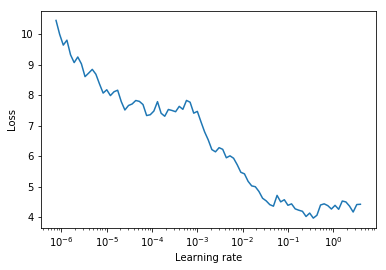

In [9]:
# Parameters
params = {'batch_size': 1,
          'shuffle': True,
          'num_workers': 0}

model = LANL_Resnet().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-7)
criterion = nn.L1Loss()
dataloader_lr = data.DataLoader(LANL_Dataset_LR(train_df), **params)

lr_find = LRFinder(model, optimizer, criterion)
lr_find.range_test(dataloader_lr)
lr_find.plot()
lr_find.reset()

In [11]:
def LANL_train(model,
               dataloaders,
               optimizer,
               criterion=nn.L1Loss(),
               num_epochs=100,
               patience=15,
               snapshot_path='./snapshots',
               model_path='./models'):
    
    train_loss_hist = []
    valid_loss_hist = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = -1
    
    early_stopping = False
    early_stopping_count = 0
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=3)
    
    for epoch in range(num_epochs):
        if not early_stopping:
            print('Epoch {}/{}'.format(epoch + 1, num_epochs))
            print('-' * 10)

            for phase in ['train', 'valid']:
                if phase == 'train':
                    model.train()
                if phase == 'valid':
                    model.eval()

                running_loss = 0.0
                
                for idx, sample in enumerate(tqdm(dataloaders[phase], total=len(dataloaders[phase]))):
                    X, y = sample['X'].float().to(device), sample['y'].float().to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        output = model(X)
                        loss = criterion(output, y)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * X.size(0)

                epoch_loss = running_loss/len(dataloaders[phase].dataset)

                print('{} loss: {:.6f}'.format(phase, epoch_loss))

                if phase == 'train':
                    train_loss_hist.append(epoch_loss)
                if phase == 'valid':
                    valid_loss_hist.append(epoch_loss)
                    scheduler.step(epoch_loss)
                    for param_group in optimizer.param_groups:
                        print(param_group['lr'])
                    if epoch_loss < best_loss or best_loss == -1:
                        early_stopping_count = 0
                        best_loss = epoch_loss
                        best_model_wts = copy.deepcopy(model.state_dict())
                        datetime_str = datetime.now().strftime("%Y%m%d-%H%M%S")
                        torch.save(best_model_wts, snapshot_path + '/snapshot_' + datetime_str + '_' + str(best_loss) + '.pt')
                    else:
                        early_stopping_count += 1
                        print('Early stopping count at {} of {}'.format(early_stopping_count, patience))
                        if early_stopping_count >= patience:
                            early_stopping = True
                            print('Out of patience, early stopping training')
            
            print()

    print('Best validation loss: {:6f}'.format(best_loss))
    
    model.load_state_dict(best_model_wts)
    datetime_str = datetime.now().strftime("%Y%m%d-%H%M%S")
    torch.save(best_model_wts, model_path + '/model_' + datetime_str + '_' + str(best_loss) + '.pt')
    
    return model, train_loss_hist, valid_loss_hist

In [12]:
# Parameters
params = {'batch_size': 2,
          'shuffle': True,
          'num_workers': 0}

datasets = {'train': LANL_Dataset(train_df),
            'valid': LANL_Dataset(valid_df),
            'test' : LANL_Dataset(test_df )}

dataloaders = {phase: data.DataLoader(dataset, **params) for phase, dataset in datasets.items()}

next(iter(dataloaders['train']))['X'].shape

torch.Size([2, 1, 150000])

In [13]:
model = LANL_Resnet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.1)

model, train_loss_hist, valid_loss_hist = LANL_train(model, dataloaders, optimizer)

  0%|          | 0/1678 [00:00<?, ?it/s]

Epoch 1/100
----------


  0%|          | 0/419 [00:00<?, ?it/s]

train loss: 2.877073


  0%|          | 0/1678 [00:00<?, ?it/s]

valid loss: 37.907525
0.1

Epoch 2/100
----------


  0%|          | 0/419 [00:00<?, ?it/s]

train loss: 2.658757


  0%|          | 0/1678 [00:00<?, ?it/s]

valid loss: 21.448591
0.1

Epoch 3/100
----------


  0%|          | 0/419 [00:00<?, ?it/s]

train loss: 2.508665


  0%|          | 0/1678 [00:00<?, ?it/s]

valid loss: 3.055803
0.1

Epoch 4/100
----------


  0%|          | 0/419 [00:00<?, ?it/s]

train loss: 2.360420


  0%|          | 0/1678 [00:00<?, ?it/s]

valid loss: 2.372118
0.1

Epoch 5/100
----------


  0%|          | 1/419 [00:00<01:20,  5.20it/s]

train loss: 2.323825


  0%|          | 0/1678 [00:00<?, ?it/s]

valid loss: 24.577510
0.1
Early stopping count at 1 of 15

Epoch 6/100
----------


  0%|          | 1/419 [00:00<01:18,  5.30it/s]

train loss: 2.313293


  0%|          | 0/1678 [00:00<?, ?it/s]

valid loss: 2.275166
0.1

Epoch 7/100
----------


  0%|          | 1/419 [00:00<01:20,  5.21it/s]

train loss: 2.274237


  0%|          | 0/1678 [00:00<?, ?it/s]

valid loss: 2.954918
0.1
Early stopping count at 1 of 15

Epoch 8/100
----------


  0%|          | 1/419 [00:00<01:17,  5.40it/s]

train loss: 2.254730


  0%|          | 0/1678 [00:00<?, ?it/s]

valid loss: 2.764751
0.1
Early stopping count at 2 of 15

Epoch 9/100
----------


  0%|          | 1/419 [00:00<01:15,  5.51it/s]

train loss: 2.250993


  0%|          | 0/1678 [00:00<?, ?it/s]

valid loss: 10.412195
0.1
Early stopping count at 3 of 15

Epoch 10/100
----------


  0%|          | 1/419 [00:00<01:22,  5.09it/s]

train loss: 2.241751


  0%|          | 0/1678 [00:00<?, ?it/s]

valid loss: 2.339761
Epoch     9: reducing learning rate of group 0 to 1.0000e-02.
0.010000000000000002
Early stopping count at 4 of 15

Epoch 11/100
----------


  0%|          | 0/419 [00:00<?, ?it/s]

train loss: 2.143728


  0%|          | 0/1678 [00:00<?, ?it/s]

valid loss: 2.830859
0.010000000000000002
Early stopping count at 5 of 15

Epoch 12/100
----------


  0%|          | 1/419 [00:00<01:21,  5.11it/s]

train loss: 2.149424


  0%|          | 0/1678 [00:00<?, ?it/s]

valid loss: 3.221115
0.010000000000000002
Early stopping count at 6 of 15

Epoch 13/100
----------


  0%|          | 0/419 [00:00<?, ?it/s]

train loss: 2.129137


  0%|          | 0/1678 [00:00<?, ?it/s]

valid loss: 16.987411
0.010000000000000002
Early stopping count at 7 of 15

Epoch 14/100
----------


  0%|          | 1/419 [00:00<01:21,  5.10it/s]

train loss: 2.117683


  0%|          | 0/1678 [00:00<?, ?it/s]

valid loss: 2.816758
Epoch    13: reducing learning rate of group 0 to 1.0000e-03.
0.0010000000000000002
Early stopping count at 8 of 15

Epoch 15/100
----------


  0%|          | 1/419 [00:00<01:22,  5.08it/s]

train loss: 2.114887


  0%|          | 0/1678 [00:00<?, ?it/s]

valid loss: 2.864149
0.0010000000000000002
Early stopping count at 9 of 15

Epoch 16/100
----------


  0%|          | 0/419 [00:00<?, ?it/s]

train loss: 2.111694


  0%|          | 0/1678 [00:00<?, ?it/s]

valid loss: 3.318504
0.0010000000000000002
Early stopping count at 10 of 15

Epoch 17/100
----------


  0%|          | 1/419 [00:00<01:20,  5.19it/s]

train loss: 2.109157


  0%|          | 0/1678 [00:00<?, ?it/s]

valid loss: 2.491905
0.0010000000000000002
Early stopping count at 11 of 15

Epoch 18/100
----------


  0%|          | 1/419 [00:00<01:21,  5.16it/s]

train loss: 2.108067


  0%|          | 0/1678 [00:00<?, ?it/s]

valid loss: 50.896138
Epoch    17: reducing learning rate of group 0 to 1.0000e-04.
0.00010000000000000003
Early stopping count at 12 of 15

Epoch 19/100
----------


  0%|          | 1/419 [00:00<01:22,  5.04it/s]

train loss: 2.100695


  0%|          | 0/1678 [00:00<?, ?it/s]

valid loss: 3.659283
0.00010000000000000003
Early stopping count at 13 of 15

Epoch 20/100
----------


  0%|          | 1/419 [00:00<01:22,  5.07it/s]

train loss: 2.111576


  0%|          | 0/1678 [00:00<?, ?it/s]

valid loss: 11.696625
0.00010000000000000003
Early stopping count at 14 of 15

Epoch 21/100
----------


  0%|          | 0/419 [00:00<?, ?it/s]

train loss: 2.105306


100%|██████████| 419/419 [01:18<00:00,  5.32it/s]

valid loss: 2.736949
0.00010000000000000003
Early stopping count at 15 of 15
Out of patience, early stopping training

Best validation loss: 2.275166


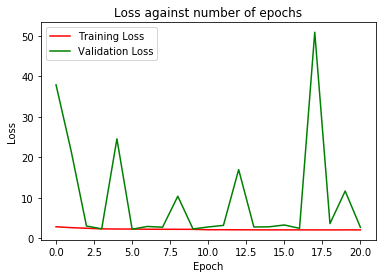

In [16]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss against number of epochs')
ax1.plot(train_loss_hist, 'r', label='Training Loss')
ax1.plot(valid_loss_hist, 'g', label='Validation Loss')
ax1.legend()

plt.show()

### Evaluating the model on the test data

In [20]:
def LANL_test(model,
              dataloaders,
              submission_path='./submissions'):
    predictions = {'seg_id': [], 'time_to_failure': []}
    model.eval()
    with torch.no_grad():
        for idx, sample in enumerate(dataloaders['test']):
                seg_id, X = sample['seg_id'], sample['X'].float().to(device)
                output = model(X)
                for i in range(X.size(0)):
                    predictions['seg_id'].append(seg_id[i])
                    predictions['time_to_failure'].append(output[i].item())
    df = pd.DataFrame.from_dict(predictions)
    datetime_str = datetime.now().strftime("%Y%m%d-%H%M%S")
    df.to_csv(submission_path + '/submission_' + datetime_str + '.csv', index=False)
    return df

In [21]:
model.load_state_dict(torch.load('./snapshots/snapshot_20190421-203949_2.2751659748093327.pt'))
predictions = LANL_test(model, dataloaders)
predictions.head()

,seg_id,time_to_failure
0,seg_5470ca,3.704945
1,seg_226e60,8.527987
2,seg_18d1d0,2.905787
3,seg_0b082e,9.472045
4,seg_0aa0fb,7.014781
